1.Pick an image of your liking and reconstruct it using matrix factorization. Choose a suitable value for the rank 
r
. Run Gradient Descent until it converges, plot the reconstructed image alongside the original image. Calculate and report the RMSE and PSNR metrics. [1 Marks]

Importing neccesary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
img = torchvision.io.read_image("../Task2/dog.jpg")
print(img.shape)
# Reading the image

torch.Size([3, 1365, 2048])


In [3]:
img = torch.tensor(img, dtype=torch.float)
# Making the image only have the H, W dimension. Basically making it grayscale
img = img.mean(dim=0, keepdim=False)
print(img.shape)

torch.Size([1365, 2048])


C:\Users\Venkat\AppData\Local\Temp\ipykernel_18800\3572128656.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float)


In [4]:
img.shape

torch.Size([1365, 2048])

In [5]:
scaled_img = MinMaxScaler().fit(img.reshape(-1, 1))
scaled_img

MinMaxScaler()

In [6]:
scaled_img = scaled_img.transform(img.reshape(-1, 1)).reshape(img.shape)
scaled_img.shape

scaled_img = torch.tensor(scaled_img)

In [7]:
scaled_img = scaled_img.to("cpu")
scaled_img

tensor([[0.1839, 0.1880, 0.1880,  ..., 0.1757, 0.1757, 0.1757],
        [0.1839, 0.1880, 0.1880,  ..., 0.1757, 0.1757, 0.1757],
        [0.1839, 0.1880, 0.1880,  ..., 0.1757, 0.1757, 0.1757],
        ...,
        [0.3134, 0.3134, 0.3174,  ..., 0.2602, 0.2561, 0.2561],
        [0.3134, 0.3134, 0.3174,  ..., 0.2602, 0.2602, 0.2561],
        [0.3134, 0.3134, 0.3174,  ..., 0.2643, 0.2602, 0.2602]],
       dtype=torch.float64)

In [8]:
scaled_img.max()

tensor(1., dtype=torch.float64)

In [9]:
scaled_img.min()

tensor(0., dtype=torch.float64)

In [10]:
scaled_img.shape

torch.Size([1365, 2048])

Doing the matrix factorization with a gray scale image

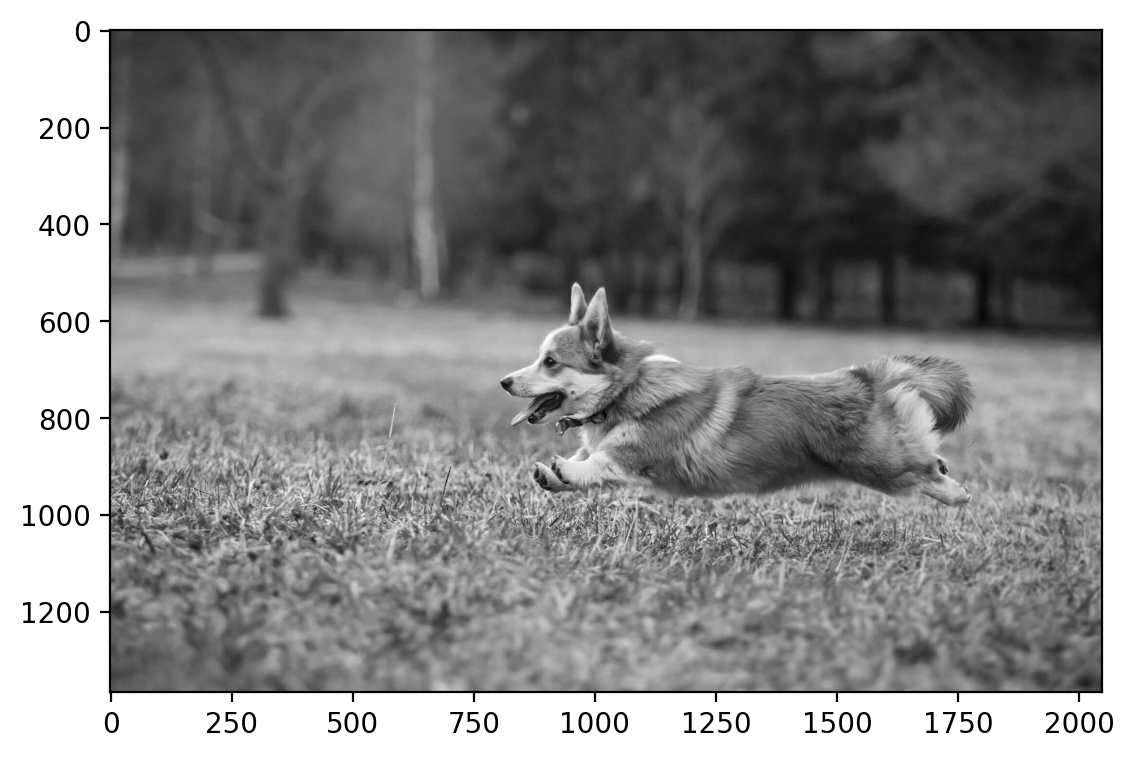

In [11]:
plt.imshow(scaled_img, cmap='gray')
# Displaying the image

In [12]:
crop = torchvision.transforms.functional.crop(scaled_img, 600, 800, 300, 300)
crop.shape

# 600: The top coordinate-->the number of pixels to move down from the top of the image to start the crop.
# 800: The left coordinate-->the number of pixels to move from the left edge of the image to start the crop.
# the last 300, 300 represent the height and width

torch.Size([300, 300])

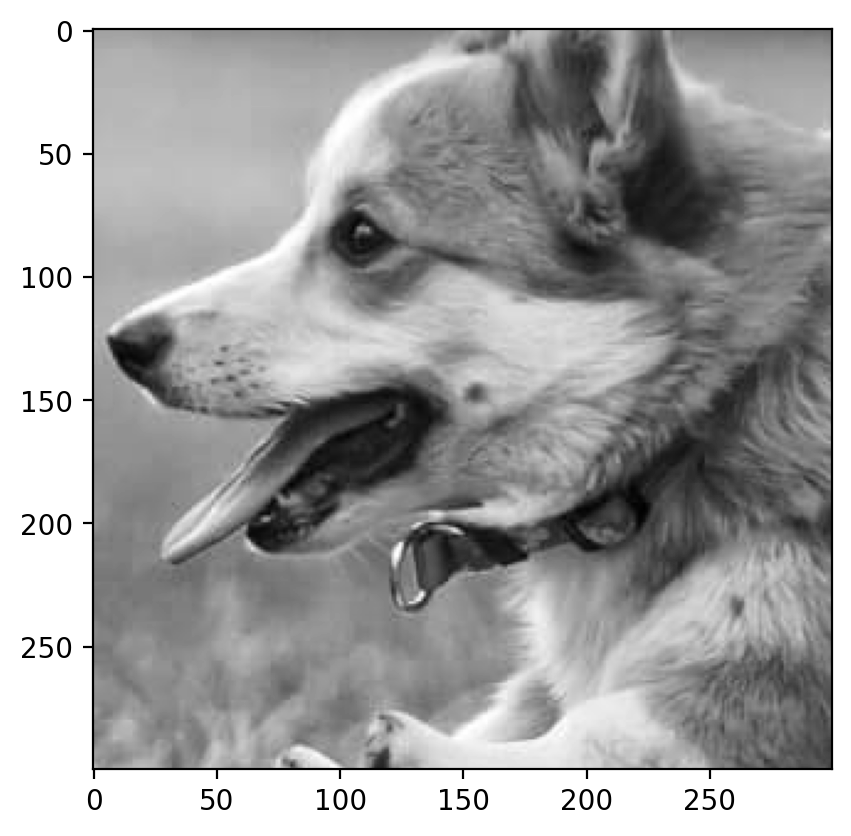

In [13]:
plt.imshow(crop, cmap='gray')
# Displaying the cropped image

In [14]:
# Mask the image with NaN values 
def mask_image(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

In [15]:
masked_img = mask_image(crop, 0.3)

In [16]:
masked_img

(tensor([[0.6308, 0.6308, 0.6308,  ..., 0.4401,    nan,    nan],
         [0.6349, 0.6349, 0.6349,  ..., 0.4578,    nan, 0.4537],
         [   nan,    nan, 0.6390,  ..., 0.4782, 0.4741, 0.4741],
         ...,
         [0.6594, 0.5967, 0.5681,  ..., 0.2861, 0.2738, 0.2507],
         [0.7166, 0.6499, 0.6022,  ..., 0.3011,    nan, 0.2480],
         [0.7548,    nan, 0.6294,  ..., 0.3202, 0.2670, 0.2589]],
        dtype=torch.float64),
 tensor([[False, False, False,  ..., False,  True,  True],
         [False, False, False,  ..., False,  True, False],
         [ True,  True, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False,  True, False],
         [False,  True, False,  ..., False, False, False]]))

In [17]:
masked_img[1].sum()

tensor(27003)

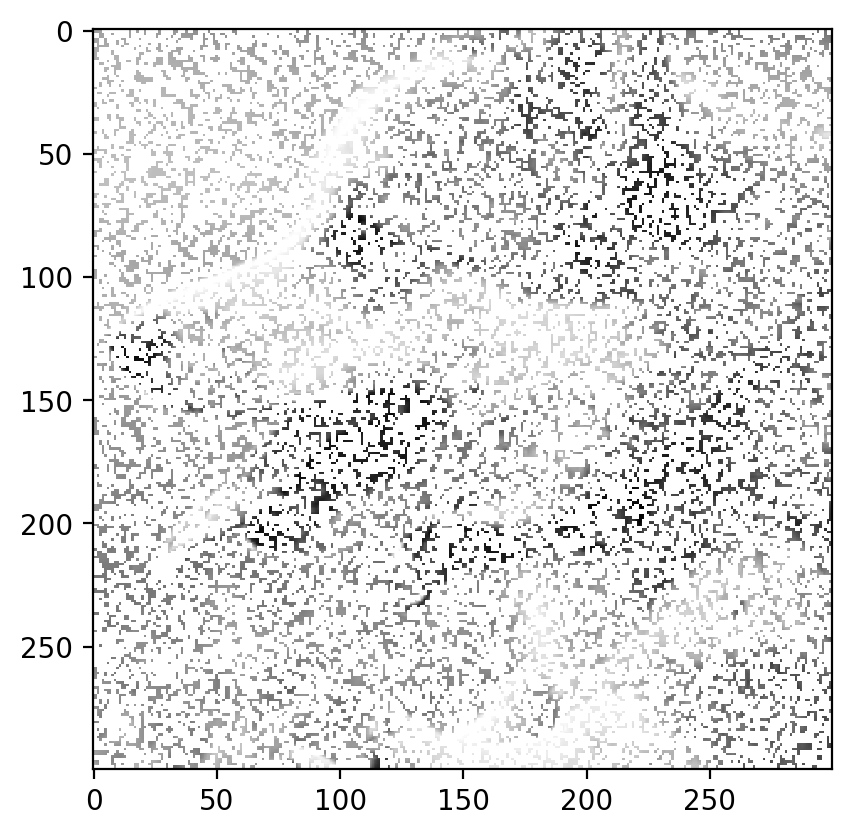

In [18]:
plt.imshow(masked_img[0], cmap='gray')

In [19]:
# Modify the loss function to ignore NaN values

def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(1000):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

In [20]:
W, H, loss = factorize(masked_img[0], 100, device='cpu')

In [21]:
loss

tensor(7.2582, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)

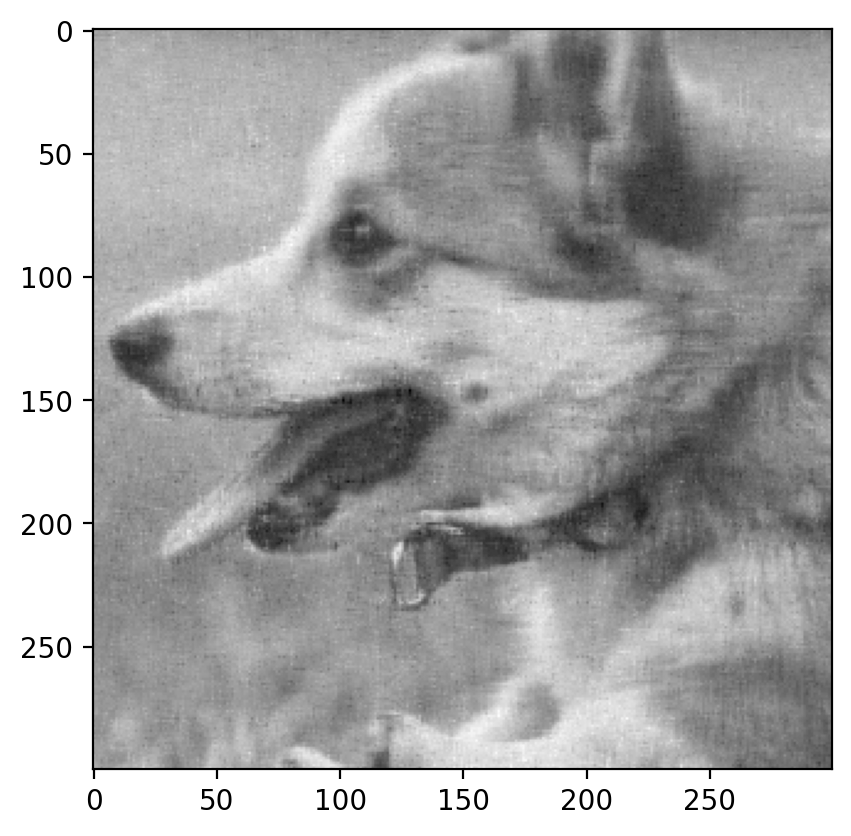

In [22]:
plt.imshow(torch.mm(W, H).cpu().detach().numpy(), cmap='gray')

In [23]:
def calculate_rmse(original, reconstructed):
    mask = ~torch.isnan(original)
    diff = original - reconstructed
    # Ignore NaN
    diff = diff[mask]

    rmse = torch.sqrt(torch.mean(diff ** 2))
    return rmse.item()

def calculate_psnr(original, reconstructed, max_pixel_value=1.0):
    rmse = calculate_rmse(original, reconstructed)
    
    # If RMSE is 0, PSNR is infinite --> perfect reconstruction
    if rmse == 0:
        return float('inf')
    
    psnr = 20 * torch.log10(torch.tensor(max_pixel_value)) - 20 * torch.log10(torch.tensor(rmse))
    return psnr.item()

original_img = masked_img[0]
reconstructed_img = torch.matmul(W, H) # It is A = W*H

rmse_value = calculate_rmse(original_img, reconstructed_img)
psnr_value = calculate_psnr(original_img, reconstructed_img)

print(f"RMSE: {rmse_value}")
print(f"PSNR: {psnr_value}")

RMSE: 0.028974411059802318
PSNR: 30.759708404541016


Doing the Matrix Factorization using a Color image

In [24]:
img.shape
# We Are not having the color dimension as we removed it earlier 

torch.Size([1365, 2048])

In [25]:
# Read in a image from torchvision
import torchvision
img = torchvision.io.read_image("../Task2/dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


In [26]:
scaled_img = MinMaxScaler().fit(img.reshape(-1, 1))
scaled_img

MinMaxScaler()

In [27]:
scaled_img = scaled_img.transform(img.reshape(-1, 1)).reshape(img.shape)
scaled_img.shape

scaled_img = torch.tensor(scaled_img)

In [28]:
scaled_img.shape

torch.Size([3, 1365, 2048])

In [29]:
crop = torchvision.transforms.functional.crop(scaled_img.cpu(), 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

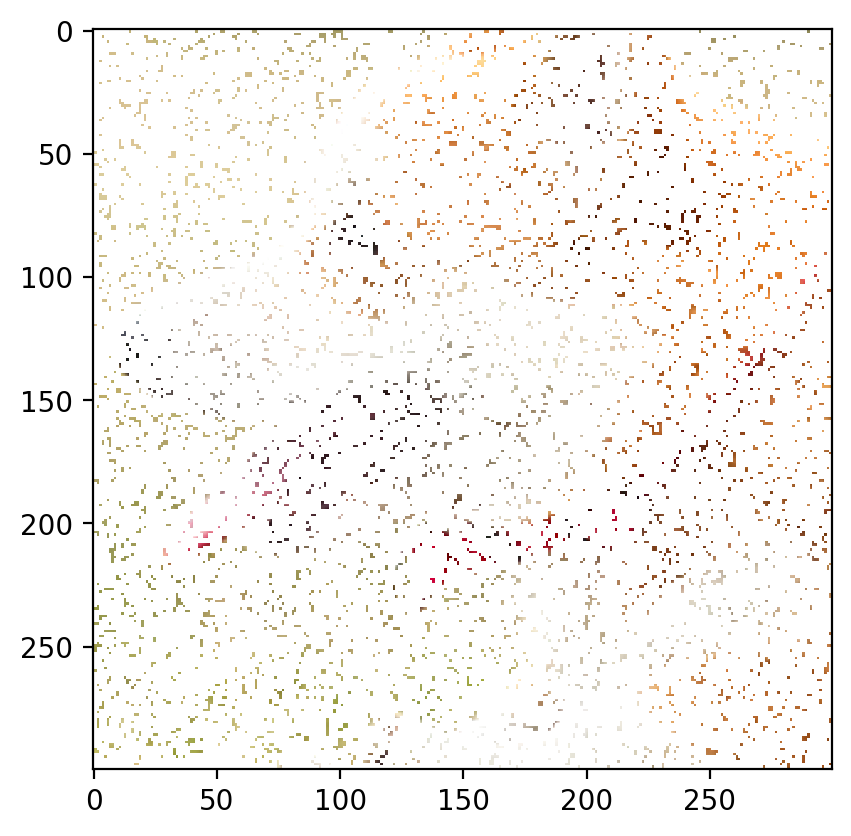

In [30]:
# Mask the image with NaN values

def mask_image_rgb(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img[0].shape) < prop
    img_copy[0][mask] = float('nan')
    img_copy[1][mask] = float('nan')
    img_copy[2][mask] = float('nan')
    return img_copy, mask

masked_img = mask_image_rgb(crop, 0.5)
img_1 = masked_img[0].cpu().numpy()

# Rearrange the dimensions
img_1 = np.transpose(img_1, (1, 2, 0))
# Torch stores images in the CHW format
# Matplotlib stores in HWC format, thus we have to convert it to 1,2,0 so that we can read the image from matplotlib

plt.imshow(img_1)
plt.show()

In [31]:
img[0].shape

torch.Size([1365, 2048])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.033371..4.282269].


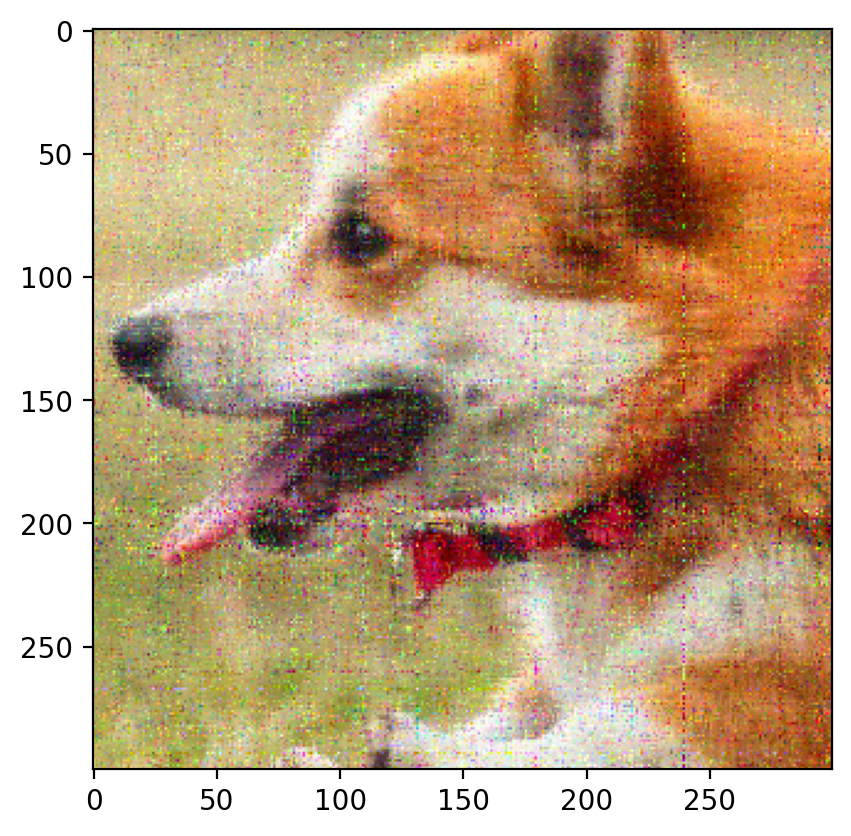

In [32]:
import torch.optim as optim
def factorize(A_colors, k, device=torch.device("cpu")):
    W_colors = []
    H_colors = []
    loss_vals = []

    # The loop will run three times for RGB
    # Each time the W, H matrix will be calulated and also the loss.
    for A in A_colors:
        A = A.to(device)

        W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
        H = torch.randn(k, A.shape[1], requires_grad=True, device=device)

        optimizer = optim.Adam([W, H], lr=0.01)
        mask = ~torch.isnan(A)

        for _ in range(1000):
            diff_matrix = torch.mm(W, H) - A # Compute the loss
            diff_vector = diff_matrix[mask]
            loss = torch.norm(diff_vector)

            # Zero the gradients
            optimizer.zero_grad() 

            # Backpropagate
            loss.backward() 

            # Update the parameters
            optimizer.step() 

        W_colors.append(W.detach().clone())
        H_colors.append(H.detach().clone())
        loss_vals.append(loss.detach().clone())

    return torch.stack(W_colors), torch.stack(H_colors), torch.stack(loss_vals)

W, H, loss = factorize(masked_img[0], 100, device="cpu")

image_np = torch.matmul(W, H).cpu().numpy()

image_np = np.transpose(image_np, (1, 2, 0))

plt.imshow(image_np)
plt.show()

In [33]:
W.shape, H.shape

(torch.Size([3, 300, 100]), torch.Size([3, 100, 300]))

In [34]:
loss

tensor([4.7215, 4.6871, 4.6852], dtype=torch.float64)

In [35]:
def calculate_rmse(original, reconstructed):
    mask = ~torch.isnan(original)
    diff = original - reconstructed
    # Ignore NaN
    diff = diff[mask]

    rmse = torch.sqrt(torch.mean(diff ** 2))
    return rmse.item()

def calculate_psnr(original, reconstructed, max_pixel_value=1.0):
    rmse = calculate_rmse(original, reconstructed)
    
    # If RMSE is 0, PSNR is infinite --> perfect reconstruction
    if rmse == 0:
        return float('inf')
    
    psnr = 20 * torch.log10(torch.tensor(max_pixel_value)) - 20 * torch.log10(torch.tensor(rmse))
    return psnr.item()

original_img = masked_img[0]
reconstructed_img = torch.matmul(W, H) # It is A = W*H

rmse_value = calculate_rmse(original_img, reconstructed_img)
psnr_value = calculate_psnr(original_img, reconstructed_img)

print(f"RMSE: {rmse_value}")
print(f"PSNR: {psnr_value}")

RMSE: 0.022056523445891988
PSNR: 33.12925720214844


Choosing an optimum value of rank k.

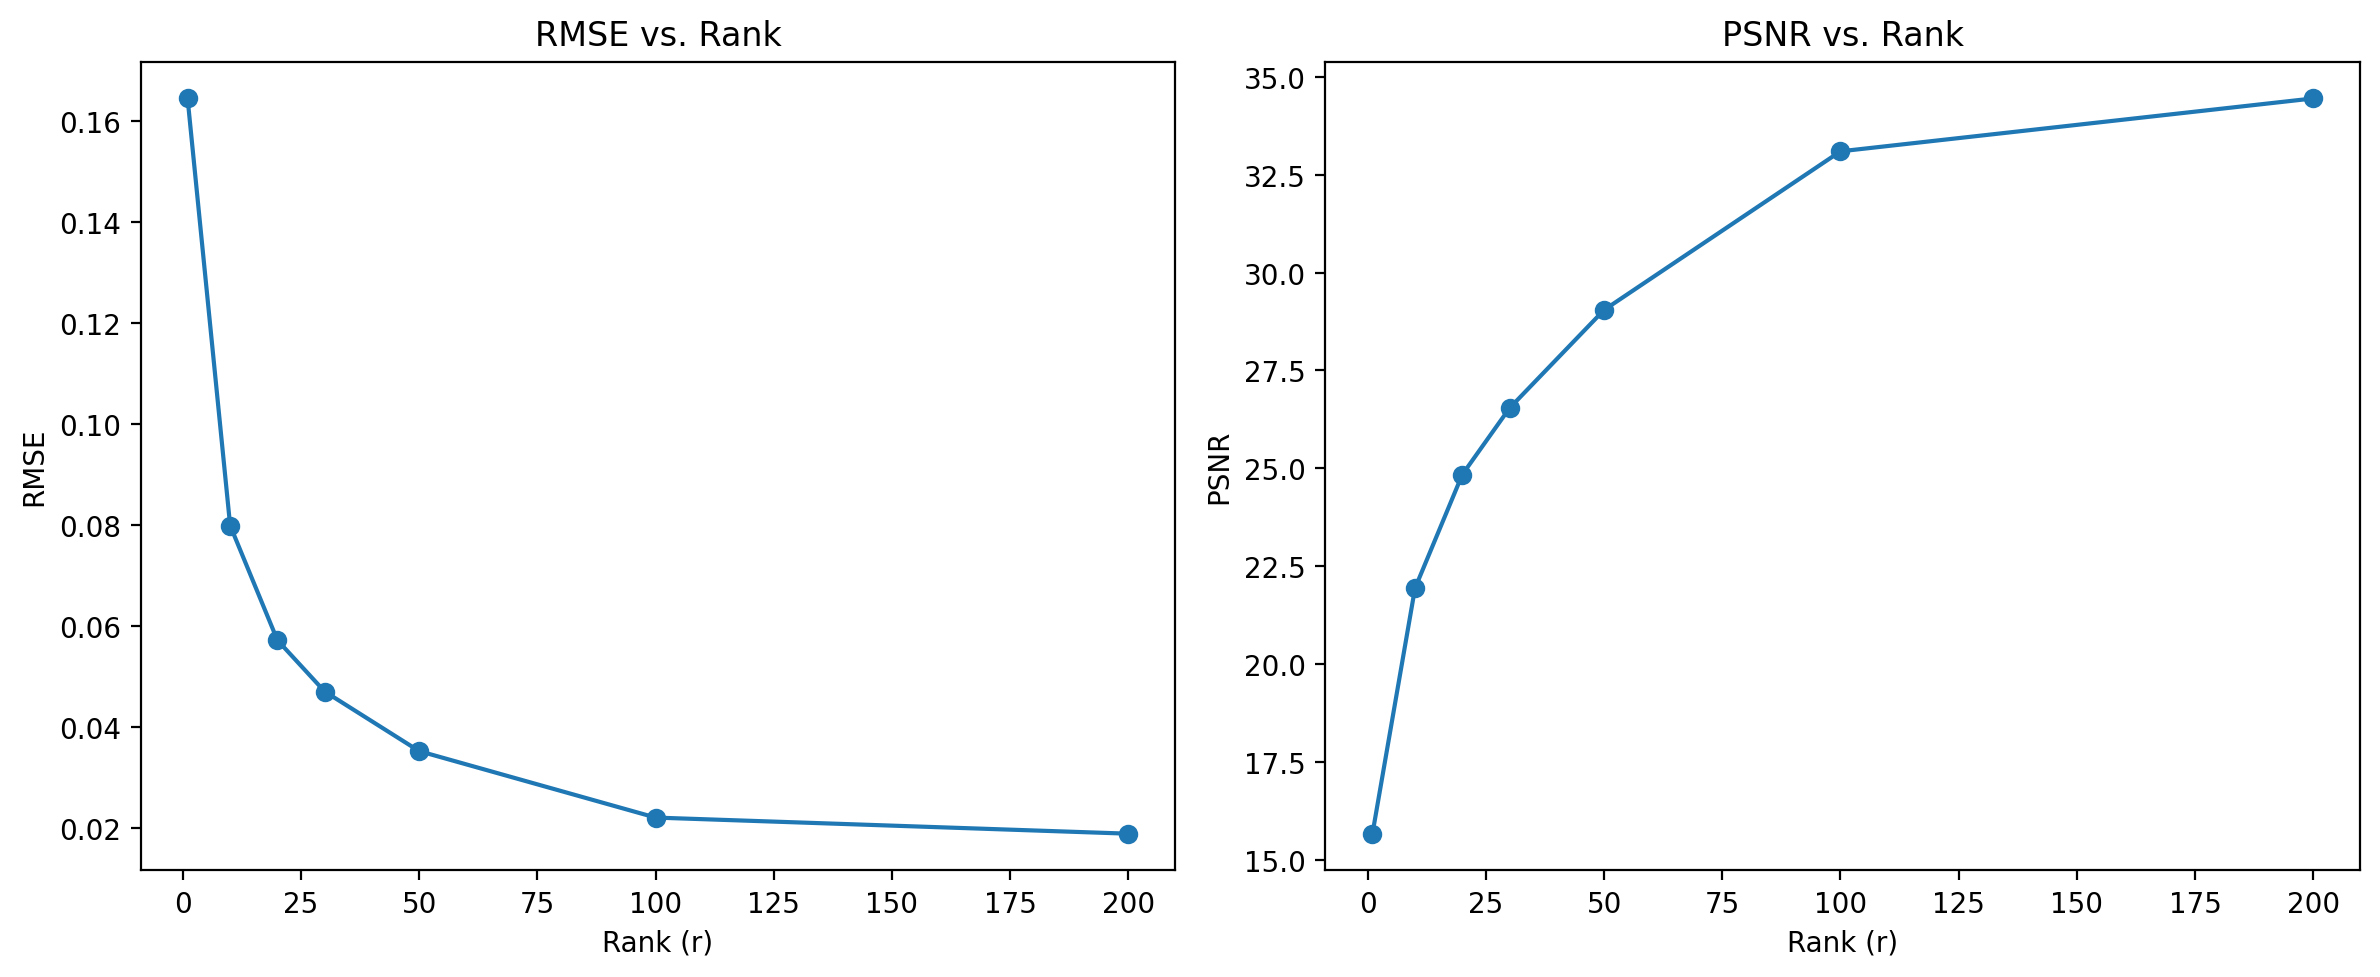

In [36]:
r_values = [1,10, 20, 30, 50, 100, 200] 
rmse_values = []
psnr_values = []

for r in r_values:
    W, H, _ = factorize(original_img, r, device="cpu")
    reconstructed_img = torch.matmul(W, H)
    rmse_value = calculate_rmse(original_img, reconstructed_img)
    psnr_value = calculate_psnr(original_img, reconstructed_img)
    
    rmse_values.append(rmse_value)
    psnr_values.append(psnr_value)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(r_values, rmse_values, marker='o')
plt.title('RMSE vs. Rank')
plt.xlabel('Rank (r)')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(r_values, psnr_values, marker='o')
plt.title('PSNR vs. Rank')
plt.xlabel('Rank (r)')
plt.ylabel('PSNR')

plt.tight_layout()
plt.show()

Low values of rank leads to underfitting and the model will have high bias as it wont be able to fit the training data propely.
If we choose very high values of rank r, it would lead to overfitting. We have to try for a perfect bias variance tradeoff and choose an appropriate value of rank r. In our case r=100 is working well.

### 2. Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.[3 Marks]

In [37]:
crop[0].numel()
# Total number of pixels
# 300 * 300

90000

In [38]:
def mask_image_rgb_fixed(img, num_missing):
    img_copy = img.clone()
    total_pixels = img[0].numel()  
    indices = torch.randperm(total_pixels)[:num_missing]
    
    for i in range(3):  
        img_copy[i].view(-1)[indices] = float('nan')
    
    return img_copy

#img_copy[i] accesses the i-th color channel.
#.view(-1) flattens the 2D (height*width) channel into a 1D tensor so that we can do indexing.


masked_img = mask_image_rgb_fixed(crop, 900)

In [39]:
W, H, loss = factorize(masked_img, 100, device="cpu")

# Reconstruct the image
reconstructed_img = torch.matmul(W, H).cpu().numpy()
reconstructed_img = np.transpose(reconstructed_img, (1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09810342..1.0920924].


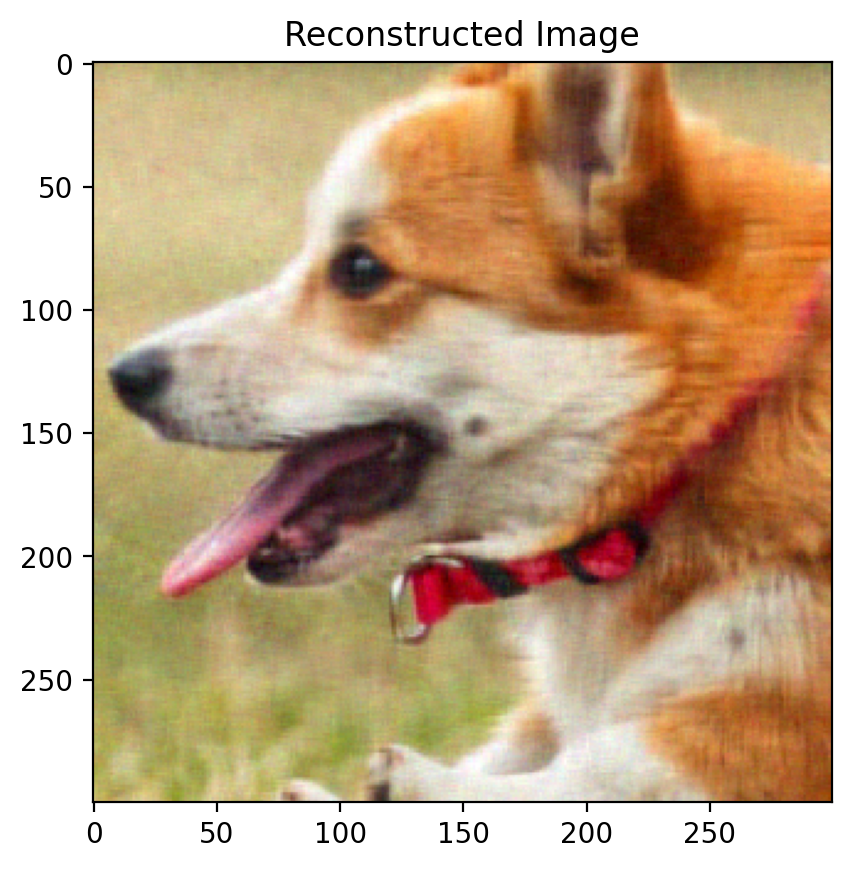

In [40]:
plt.imshow(reconstructed_img)
plt.title("Reconstructed Image")
plt.show()


In [41]:
original_img = masked_img
reconstructed_img = torch.matmul(W, H)

# Calculate RMSE and PSNR
rmse_value = calculate_rmse(original_img, reconstructed_img)
psnr_value = calculate_psnr(original_img, reconstructed_img)

print(f"RMSE: {rmse_value}")
print(f"PSNR: {psnr_value}")

RMSE: 0.031547512545941896
PSNR: 30.02069664001465


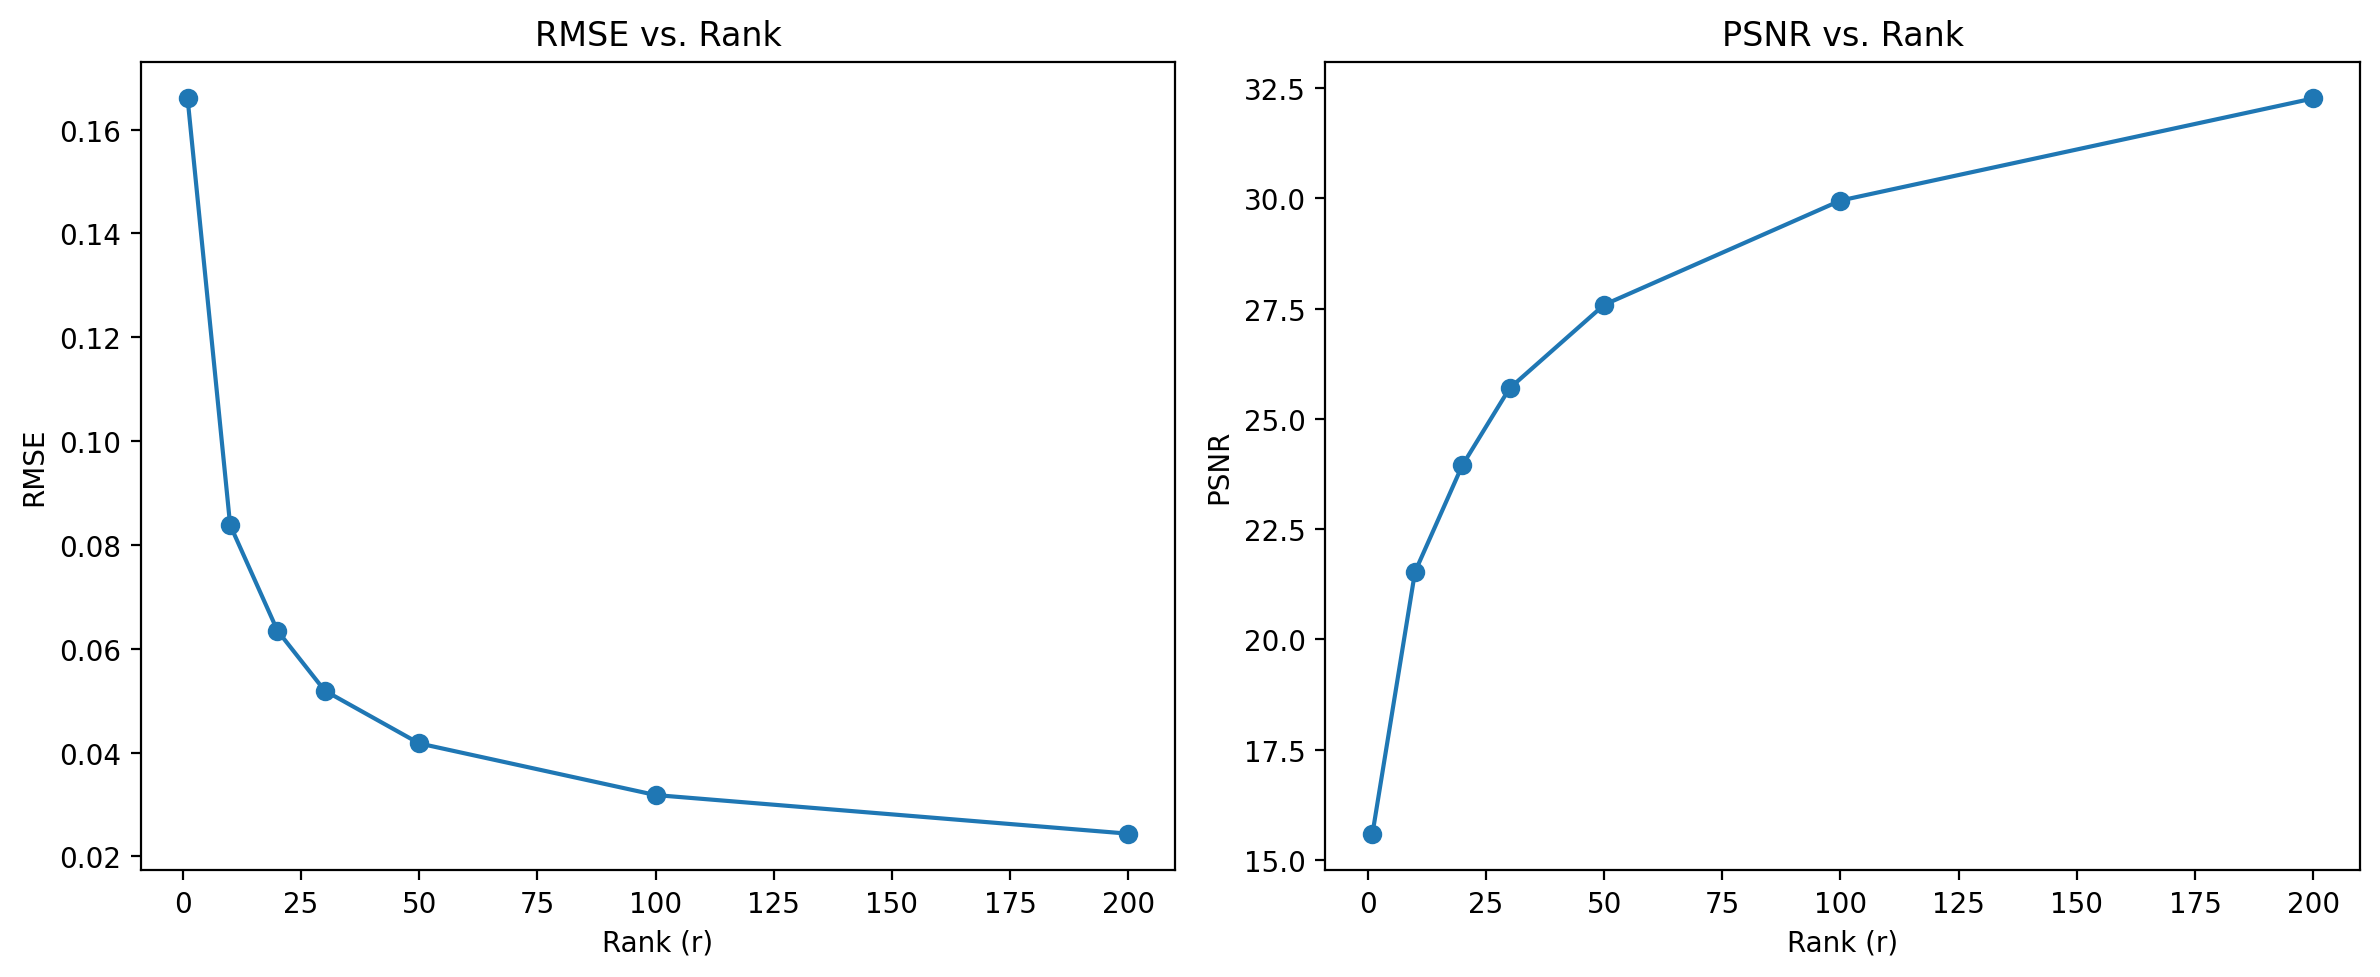

In [42]:
r_values = [1, 10, 20, 30, 50, 100, 200] 
rmse_values = []
psnr_values = []

for r in r_values:
    W, H, _ = factorize(original_img, r, device="cpu")
    reconstructed_img = torch.matmul(W, H)
    rmse_value = calculate_rmse(original_img, reconstructed_img)
    psnr_value = calculate_psnr(original_img, reconstructed_img)
    
    rmse_values.append(rmse_value)
    psnr_values.append(psnr_value)

# Plot RMSE and PSNR vs. Rank
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(r_values, rmse_values, marker='o')
plt.title('RMSE vs. Rank')
plt.xlabel('Rank (r)')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(r_values, psnr_values, marker='o')
plt.title('PSNR vs. Rank')
plt.xlabel('Rank (r)')
plt.ylabel('PSNR')

plt.tight_layout()
plt.show()

Matrix factorization is a better approach for missing pixels case as it gives more interpretability, while rff is a black box and we do not know what exactly is happening.